# **Seminar: Politische Debatten & Polarisierung im Bundestag**
## Sentimentanalyse im Kontext von Corona

## 1. Packages installieren

In [4]:
# Import Basic Packages
import numpy as np                 # Numpy
import pandas as pd                 #Datafrane

# Import Visualization Packages
from collections import Counter     # um worte zu zählen
import matplotlib.pyplot as plt   # Für Visualisierung
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #Wordcloud erstellen
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp


# Import NLP Packages
import nltk
pd.options.mode.chained_assignment = None



## 2. Methoden

In [5]:
def find_speeches_with_word(search_term, speeches):
    filtered_speeches = []
    for speech in speeches:
        if ( search_term in speech['text'] ):
            filtered_speeches.append(speech)
    return filtered_speeches

## 3. Datensatz

### Datensatz einlesen

In [6]:
# df Legislaturperiode 2019 (24.10.2017-26.09.21)
df19 = pd.read_json('/Users/paulahofmann/Documents/Python/Politische Debatten/Data/speeches_19.jsonl', lines=True)
df19['date'] = pd.to_datetime(df19['date'])
df19.sort_values(by='date')

#Datensatz filtern Nach Recherche wird zuerst nur Datensatz über die 158.Sitzung gedownloadet. hier insbesondere der Tagesordnungspunkt 15: https://dserver.bundestag.de/btp/19/19158.pdf#P.19551
df_grundrechte = df19[df19['date']=="2020-05-07"] #Selektieren des Datums
df_grundrechte = df_grundrechte[df_grundrechte['discussion_title']=="Tagesordnungspunkt 15 2020-05-07"] #Selektieren Tagesordnungspunkt

df_ausgang = df_grundrechte.copy ()
#Ausgabe der ersten 3 Zeilen
df_grundrechte.head (11)

,text,id,period,date,name,party,redner_id,discussion_title
24227,Herr Präsident! Meine Damen und Herren! Das Fr...,ID1915801800,19,2020-05-07,Beatrix Storch,AfD,11004905,Tagesordnungspunkt 15 2020-05-07
24228,Herr Präsident! Liebe Kolleginnen und Kollegen...,ID1915801900,19,2020-05-07,Philipp Amthor,CDU/CSU,11004656,Tagesordnungspunkt 15 2020-05-07
24229,Herr Präsident! Meine Damen und Herren! Ich ha...,ID1915802000,19,2020-05-07,Konstantin Kuhle,FDP,11004796,Tagesordnungspunkt 15 2020-05-07
24230,Sehr geehrter Herr Präsident! Liebe Kolleginne...,ID1915802100,19,2020-05-07,Mahmut Özdemir,SPD,11004368,Tagesordnungspunkt 15 2020-05-07
24231,Frau Präsidentin! Meine Damen und Herren! Kein...,ID1915802200,19,2020-05-07,André Hahn,DIE LINKE,11004288,Tagesordnungspunkt 15 2020-05-07
24232,Vielen Dank. – Frau Präsidentin! Liebe Kollegi...,ID1915802300,19,2020-05-07,Canan Bayram,BÜNDNIS 90/DIE GRÜNEN,11004665,Tagesordnungspunkt 15 2020-05-07
24233,"Sie wissen ja nicht, wie ich mich heute fühle....",ID1915802400,19,2020-05-07,Karsten Hilse,AfD,11004752,Tagesordnungspunkt 15 2020-05-07
24234,"Vielen Dank, Frau Präsidentin. – In aller Kürz...",ID1915802500,19,2020-05-07,Canan Bayram,BÜNDNIS 90/DIE GRÜNEN,11004665,Tagesordnungspunkt 15 2020-05-07
24235,Sehr geehrte Frau Präsidentin! Liebe Kolleginn...,ID1915802600,19,2020-05-07,Christoph Bernstiel,CDU/CSU,11004671,Tagesordnungspunkt 15 2020-05-07
24236,Sehr geehrte Frau Präsidentin! Werte Kollegen!...,ID1915802700,19,2020-05-07,Joana Cotar,AfD,11004696,Tagesordnungspunkt 15 2020-05-07


### Datensatz bearbeiten

In [7]:
#Jeden Satz als einzelne Zeile. Nach "." erfolgt Trennung. 
df_grundrechte['text'] = df_grundrechte['text'].str.split('[.]')
df_grundrechte = df_grundrechte.explode('text').reset_index(drop=True)
cols = list(df_grundrechte.columns)
cols.append(cols.pop(cols.index('name')))
df_grundrechte = df_grundrechte[cols]

#Ausgabe der ersten 3 Zeilen
df_grundrechte.head (3)

df_grundrechte.dropna

<bound method DataFrame.dropna of                                                   text            id  period  \
0    Herr Präsident! Meine Damen und Herren! Das Fr...  ID1915801800      19   
1     Sechs Wochen lang wurde Deutschland praktisch...  ID1915801800      19   
2          Unser Antrag will das in Zukunft verhindern  ID1915801800      19   
3     Regiert wurde Deutschland de facto von der Bu...  ID1915801800      19   
4     Das Grundgesetz kennt einen solchen Notstand ...  ID1915801800      19   
..                                                 ...           ...     ...   
591   Und diese Ziele, meine Damen und Herren, könn...  ID1915803200      19   
592                                        Vielen Dank  ID1915803200      19   
593                     Vielen Dank, Stephan Pilsinger  ID1915803200      19   
594                – Damit schließe ich die Aussprache  ID1915803200      19   
595                                                     ID1915803200      19   

     

## Daten bereinigen

In [8]:
#Alles in Kleinschreibung
df_grundrechte['text'] = df_grundrechte['text'].astype(str).str.lower()


#Tokenization
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer('\w+')
df_grundrechte['text_token']=df_grundrechte['text'].apply(regexp.tokenize)

#Entfernen von Stoppwörter
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('german'))- {'nicht'}  #Stoppliste befüllen mit German-Stopwordlist von NLTK, entfernen von "nicht" aus Stoppwort-Liste

#Erweiterung der Stoppwort-Liste
my_stopwords = ['ministerin','minister','kollege','kollegin','präsidentin','kolleginnen','kollegen','frau','herr','mann','geehrte','geehrter','liebe','lieber','damen','herren','präsident']
stops.update(my_stopwords)
df_grundrechte['text_token'] = df_grundrechte['text_token'].apply(lambda x: [item for item in x if item not in stops])

#Neue Variable, in der einzelne Text-Token wieder zu String zusammengesetzt werden 
df_grundrechte['clean text']= df_grundrechte['text_token'].str.join(' ')
df_grundrechte.head(7)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulahofmann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,id,period,date,party,redner_id,discussion_title,name,text_token,clean text
0,herr präsident! meine damen und herren! das fr...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[frühjahr, 2020, lange, erinnerung, bleiben]",frühjahr 2020 lange erinnerung bleiben
1,sechs wochen lang wurde deutschland praktisch...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[sechs, wochen, lang, wurde, deutschland, prak...",sechs wochen lang wurde deutschland praktisch ...
2,unser antrag will das in zukunft verhindern,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[antrag, zukunft, verhindern]",antrag zukunft verhindern
3,regiert wurde deutschland de facto von der bu...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[regiert, wurde, deutschland, de, facto, bunde...",regiert wurde deutschland de facto bundeskanzl...
4,das grundgesetz kennt einen solchen notstand ...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[grundgesetz, kennt, notstand, verteidigungsfa...",grundgesetz kennt notstand verteidigungsfall n...
5,für den coronaausnahmezustand mit einer so we...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[coronaausnahmezustand, weitreichenden, außerk...",coronaausnahmezustand weitreichenden außerkraf...
6,das grundgesetz erlaubt zwar die einschränkun...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[grundgesetz, erlaubt, einschränkung, grundrec...",grundgesetz erlaubt einschränkung grundrechten...


In [9]:
# Erstellen einer Liste von Text mit Stopwords (=unbereinigter Text)
corpus1 = list(df_grundrechte['text'].values)

df_grundrechte_original = df_grundrechte.copy()
#df_grundrechte_original = df_grundrechte_original.drop('clean text', axis=1)


# Erstellen einer Liste von Text ohne Stopwords (=Bereinigter Text)
corpus2 = list(df_grundrechte['clean text'].values)

df_grundrechte_cleaned = df_grundrechte.copy()
#df_grundrechte_cleaned = df_grundrechte_cleaned.drop(columns=['text'])

## 4. Deskriptive Datenanalyse

In [10]:
tokens =list(df_grundrechte ['clean text'].values)

for text in tokens:
    unigrams = text.split()
    unigram_counts = {}
    for unigram in unigrams:
        unigram_counts[unigram] = unigram_counts.get(unigram, 0) +1

    bigrams = [",".join(bigram) for bigram in zip(unigrams[:-1], unigrams[1:])]
    bigram_counts = {}
    for bigram in bigrams:
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) +1

    trigrams = [",".join(trigram) for trigram in zip(unigrams[:-2], unigrams[1:-1],unigrams[2:])]
    trigram_counts = {}
    for trigram in trigrams:
        trigram_counts[trigram] = trigram_counts.get(trigram, 0) +1

    print(bigram_counts)

    print(trigram_counts)


{'frühjahr,2020': 1, '2020,lange': 1, 'lange,erinnerung': 1, 'erinnerung,bleiben': 1}
{'frühjahr,2020,lange': 1, '2020,lange,erinnerung': 1, 'lange,erinnerung,bleiben': 1}
{'sechs,wochen': 1, 'wochen,lang': 1, 'lang,wurde': 1, 'wurde,deutschland': 1, 'deutschland,praktisch': 1, 'praktisch,notstandsregime': 1, 'notstandsregime,geführt': 1, 'geführt,geschichte': 1, 'geschichte,bundesrepublik': 1, 'bundesrepublik,beispiel': 1}
{'sechs,wochen,lang': 1, 'wochen,lang,wurde': 1, 'lang,wurde,deutschland': 1, 'wurde,deutschland,praktisch': 1, 'deutschland,praktisch,notstandsregime': 1, 'praktisch,notstandsregime,geführt': 1, 'notstandsregime,geführt,geschichte': 1, 'geführt,geschichte,bundesrepublik': 1, 'geschichte,bundesrepublik,beispiel': 1}
{'antrag,zukunft': 1, 'zukunft,verhindern': 1}
{'antrag,zukunft,verhindern': 1}
{'regiert,wurde': 1, 'wurde,deutschland': 1, 'deutschland,de': 1, 'de,facto': 1, 'facto,bundeskanzlerin': 1, 'bundeskanzlerin,ministerpräsidenten': 1, 'ministerpräsidenten,ve

## 5. Sentimentanalyse

### Packages für Sentimentanalyse

In [14]:
from transformers import pipeline
from germansentiment import SentimentModel

# Definieren des Modells
nlp_sentiment = pipeline("sentiment-analysis", model='oliverguhr/german-sentiment-bert')


2023-06-21 09:06:56.502985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [15]:
# Wir starten mit der Modell Entwicklung auf Basis des unbereinigten Texts (= Corpus 1)
df_grundrechte_original["Sentiment"] = nlp_sentiment(corpus1) #Anwendung des transformer Modells

# Labelzuordnung, damit Sentiment und Score leichter lesbar in df
df_grundrechte_original['Sentiment_Label'] = [x.get('label') for x in df_grundrechte_original['Sentiment']]
df_grundrechte_original['Sentiment_Score'] = [x.get('score') for x in df_grundrechte_original['Sentiment']]

#Variable Sentiment Score+Label in je einer Zelle wird gelöscht
df_grundrechte_original = df_grundrechte_original.drop(columns=['Sentiment'])

df_grundrechte_original.head(15)

,text,id,period,date,party,redner_id,discussion_title,name,text_token,clean text,Sentiment_Label,Sentiment_Score
0,herr präsident! meine damen und herren! das fr...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[frühjahr, 2020, lange, erinnerung, bleiben]",frühjahr 2020 lange erinnerung bleiben,neutral,0.982748
1,sechs wochen lang wurde deutschland praktisch...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[sechs, wochen, lang, wurde, deutschland, prak...",sechs wochen lang wurde deutschland praktisch ...,neutral,0.999989
2,unser antrag will das in zukunft verhindern,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[antrag, zukunft, verhindern]",antrag zukunft verhindern,neutral,0.988218
3,regiert wurde deutschland de facto von der bu...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[regiert, wurde, deutschland, de, facto, bunde...",regiert wurde deutschland de facto bundeskanzl...,neutral,0.999991
4,das grundgesetz kennt einen solchen notstand ...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[grundgesetz, kennt, notstand, verteidigungsfa...",grundgesetz kennt notstand verteidigungsfall n...,neutral,0.999991
5,für den coronaausnahmezustand mit einer so we...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[coronaausnahmezustand, weitreichenden, außerk...",coronaausnahmezustand weitreichenden außerkraf...,neutral,0.999991
6,das grundgesetz erlaubt zwar die einschränkun...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[grundgesetz, erlaubt, einschränkung, grundrec...",grundgesetz erlaubt einschränkung grundrechten...,neutral,0.999989
7,unter dem eindruck der coronakrise hat die ex...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[eindruck, coronakrise, exekutive, grundrechte...",eindruck coronakrise exekutive grundrechte dra...,neutral,0.999989
8,"jeder tag, an dem dieser zustand andauert, un...",ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[tag, zustand, andauert, untergräbt, fundament...",tag zustand andauert untergräbt fundament unse...,neutral,0.999961
9,die bundeskanzlerin hat die notwendige debatt...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[bundeskanzlerin, notwendige, debatte, lockdow...",bundeskanzlerin notwendige debatte lockdown lo...,neutral,0.999945


In [42]:
# Wir starten mit der Modellentwicklung auf Basis des bereinigten Texts (= Corpus 2)

df_grundrechte_cleaned["Sentiment"] = nlp_sentiment(corpus2)
df_grundrechte_cleaned['Sentiment_Label'] = [x.get('label') for x in df_grundrechte_cleaned['Sentiment']]

df_grundrechte_cleaned['Sentiment_Score'] = [x.get('score') for x in df_grundrechte_cleaned['Sentiment']]

df_grundrechte_cleaned = df_grundrechte_cleaned.drop(columns=['Sentiment'])
df_grundrechte_cleaned.head(15)

,text,id,period,date,party,redner_id,discussion_title,name,text_token,clean text,Sentiment_Label,Sentiment_Score
0,herr präsident! meine damen und herren! das fr...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[frühjahr, 2020, lange, erinnerung, bleiben]",frühjahr 2020 lange erinnerung bleiben,neutral,0.997010
1,sechs wochen lang wurde deutschland praktisch...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[sechs, wochen, lang, wurde, deutschland, prak...",sechs wochen lang wurde deutschland praktisch ...,neutral,0.999985
2,unser antrag will das in zukunft verhindern,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[antrag, zukunft, verhindern]",antrag zukunft verhindern,neutral,0.987324
3,regiert wurde deutschland de facto von der bu...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[regiert, wurde, deutschland, de, facto, bunde...",regiert wurde deutschland de facto bundeskanzl...,neutral,0.999985
4,das grundgesetz kennt einen solchen notstand ...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[grundgesetz, kennt, notstand, verteidigungsfa...",grundgesetz kennt notstand verteidigungsfall n...,neutral,0.999245
5,für den coronaausnahmezustand mit einer so we...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[coronaausnahmezustand, weitreichenden, außerk...",coronaausnahmezustand weitreichenden außerkraf...,neutral,0.999982
6,das grundgesetz erlaubt zwar die einschränkun...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[grundgesetz, erlaubt, einschränkung, grundrec...",grundgesetz erlaubt einschränkung grundrechten...,neutral,0.999974
7,unter dem eindruck der coronakrise hat die ex...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[eindruck, coronakrise, exekutive, grundrechte...",eindruck coronakrise exekutive grundrechte dra...,neutral,0.988295
8,"jeder tag, an dem dieser zustand andauert, un...",ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[tag, zustand, andauert, untergräbt, fundament...",tag zustand andauert untergräbt fundament unse...,neutral,0.997079
9,die bundeskanzlerin hat die notwendige debatt...,ID1915801800,19,2020-05-07,AfD,11004905,Tagesordnungspunkt 15 2020-05-07,Beatrix Storch,"[bundeskanzlerin, notwendige, debatte, lockdow...",bundeskanzlerin notwendige debatte lockdown lo...,neutral,0.993174


In [46]:
#Festellen der Unterschiede bzgl. der Sentiment-Klassifizierung, dafür werden beide Dataframe zusammengefügt und miteinader verglichen, wo sich die Sentiment Klassifizierung unterscheidet

df_difference = df_grundrechte_original.copy ()
df_difference = df_difference.drop (columns=['id','period','date','discussion_title','text_token'],axis=1)

df_difference ['Sentiment_Cleaned']=df_grundrechte_cleaned['Sentiment_Label']
df_difference ['Score_Cleaned']=df_grundrechte_cleaned['Sentiment_Score']

df_difference['que'] = np.where((df_difference['Sentiment_Label'] == df_difference['Sentiment_Cleaned']), df_difference['Sentiment_Label'], np.nan)

df_difference=df_difference[df_difference['que'].isna()]
df_difference=df_difference.drop(['que', 'redner_id','party'], axis=1)


In [51]:
# Zählen der Häufigkeit je Sentiment
df1_count = df_grundrechte_original['Sentiment_Label'].value_counts()

df2_count = df_grundrechte_cleaned ['Sentiment_Label'].value_counts()

# Set the color palette
colors = {'Positive': 'mediumseagreen', 'Negative': 'crimson', 'Neutral': 'royalblue'}

# Balkendiagramm Häufigkeitsverteilung Sentiment 
figure1 = px.bar(x=df1_count.index, y=df1_count.values, color=df1_count.index,
             color_discrete_map=colors)
figure2 = px.bar(x=df2_count.index, y=df2_count.values, color=df2_count.index,
             color_discrete_map=colors)

# Beschriftung und Titel anpassen
figure1.update_layout(title_text='Verteilung Sentiment Original Text', title_font_size=24,
                  xaxis_title='Sentiment', yaxis_title='Count',width=800,height=600)

figure2.update_layout(title_text='Verteilung Sentiment Cleaned Text', title_font_size=24,
                  xaxis_title='Sentiment', yaxis_title='Count', width=800,height=600)

#Ausgabe der Plots
figure1.show ()
figure2.show ()

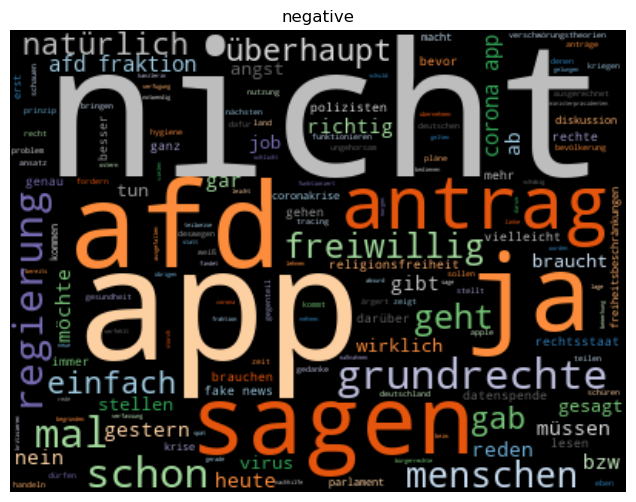

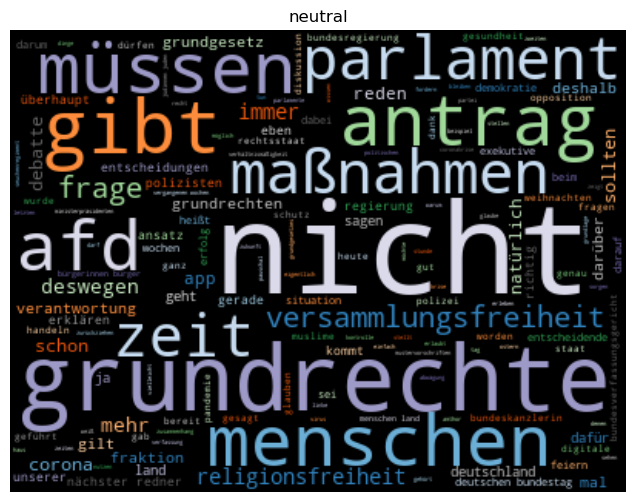

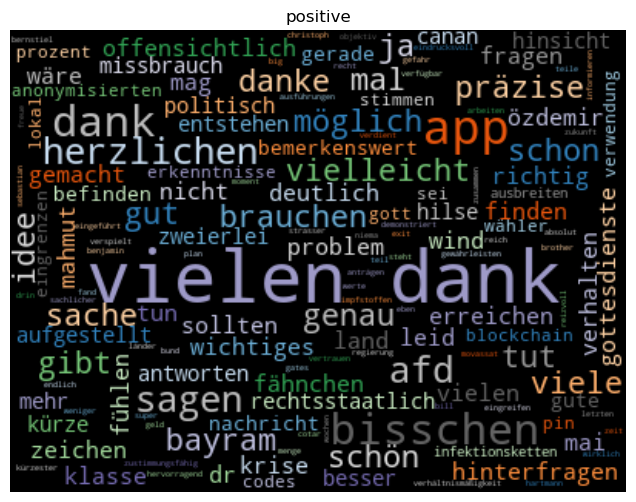

In [61]:
# Gruppieren der Tweets nach Sentiment 
sentiment_groups = df_grundrechte_cleaned.groupby('Sentiment_Label')
text_by_sentiment = {}
for sentiment, group in sentiment_groups:
    text_by_sentiment[sentiment] = ' '.join(group['clean text'].tolist())

# Generate a wordcloud for each sentiment
for sentiment, text in text_by_sentiment.items():
    wordcloud = WordCloud(background_color='black', width=400, height=300,max_words=150,
                      colormap='tab20c',).generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(sentiment)
    plt.show()

### Sentiment-Analyse nach Parteizugehörigkeit

In [52]:
# Gruppieren der Daten nach Parteizugehörigkeit
party_sentiment = df_grundrechte_cleaned.groupby(['party', 'Sentiment_Label']).size().reset_index(name='Count')

# df für jede Sentiment nach Parteizugehörigkeit
positive_df = party_sentiment[party_sentiment['Sentiment_Label'] == 'positive']
negative_df = party_sentiment[party_sentiment['Sentiment_Label'] == 'negative']
neutral_df = party_sentiment[party_sentiment['Sentiment_Label'] == 'neutral']

# Plotting 
fig = go.Figure()

fig.add_trace(go.Bar(x=positive_df['party'], y=positive_df['Count'], name='Positive', marker_color='mediumseagreen'))
fig.add_trace(go.Bar(x=negative_df['party'], y=negative_df['Count'], name='Negative', marker_color='crimson'))
fig.add_trace(go.Bar(x=neutral_df['party'], y=neutral_df['Count'], name='Neutral', marker_color='royalblue'))

fig.update_layout(barmode='group', xaxis_title='Partei', yaxis_title='Anzahl an Sätzen', title='Sentiment-Verteilung nach Parteizugehörigkeit')
fig.show()